In [1]:
import os

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from stapep.filter import Filter

# 设置绘图样式
sns.set_style('whitegrid')
colors = sns.color_palette('pastel')

Table of Contents
-----------------
*   Dataset Overview
*   Data Preprocessing
    *   Duplicate Peptide Removal
    *   Length Restriction
    *   Clustering-based Filtering (Optional)
*   Feature Analysis
    *   Feature Distribution Analysis
*   Machine Learning Model Construction
    *   Model Selection
    *   Model Evaluation
*   Feature Importance Analysis

In [2]:
# We collected 585 permeability data of peptides from the literature, 
df = pd.read_csv('../example/datasets/Stapled-peptide_permeability.csv')
df.shape

(585, 21)

In [3]:
# Permeability is the label (yes or no)
# while 'length', 'weight', 'helix_percent', 'sheet_percent', 
#       'loop_percent', 'mean_bfactor', 'mean_gyrate', 'hydrophobic_index', 
#       'num_hbonds', 'charge', 'aromaticity', 'isoelectric_point', 
#       'fraction_arginine', 'fraction_lysine', 'psa', 'sasa', 
#       and 'lyticity_index' are features.

df.columns

Index(['SEQUENCE', 'Permeability', 'length', 'weight', 'helix_percent',
       'sheet_percent', 'loop_percent', 'mean_bfactor', 'mean_gyrate',
       'hydrophobic_index', 'num_hbonds', 'charge', 'aromaticity',
       'isoelectric_point', 'fraction_arginine', 'fraction_lysine', 'psa',
       'sasa', 'lyticity_index', 'SMILES', 'name'],
      dtype='object')

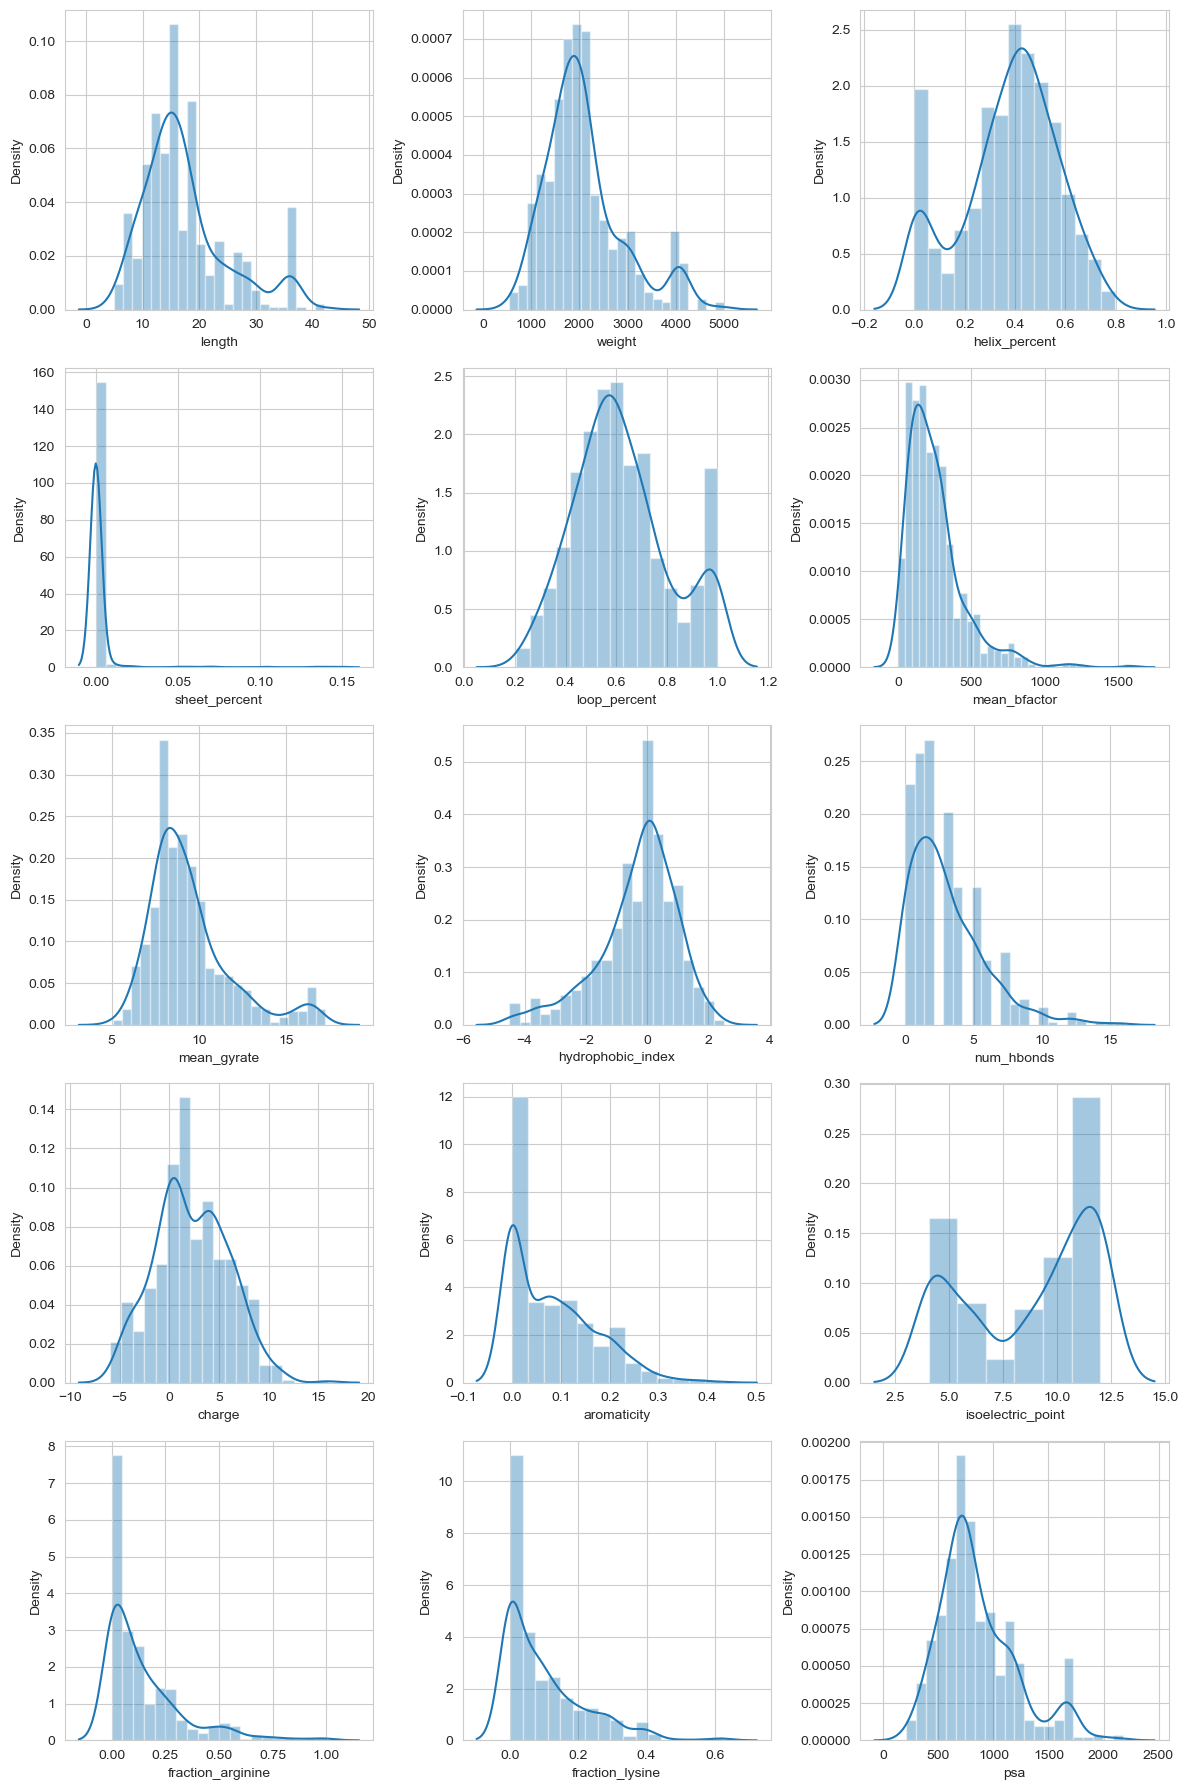

In [4]:
# We first observe the distribution of these features
cols = ['length', 'weight', 'helix_percent',
        'sheet_percent', 'loop_percent', 'mean_bfactor', 'mean_gyrate',
        'hydrophobic_index', 'num_hbonds', 'charge', 'aromaticity',
        'isoelectric_point', 'fraction_arginine', 'fraction_lysine', 'psa']

fig, axes = plt.subplots(5, 3, figsize=(12, 18))
for i, col in enumerate(cols):
    sns.distplot(df[col], ax=axes[i//3, i%3])
plt.tight_layout()

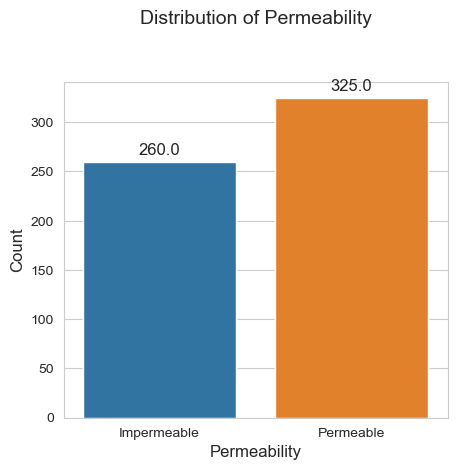

In [5]:
# The training dataset contains 585 peptides, 
# out of which 325 are membrane-permeable and 260 are not. 
# It seems to be a reasonably balanced dataset.

df['Permeability'] = df['Permeability'].replace({'yes': 'Permeable', 'no': 'Impermeable'})

fig, ax = plt.subplots()
sns.countplot(x='Permeability', data=df, ax=ax)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height), xytext=(0, 3),
                textcoords='offset points', ha='center', va='bottom', fontsize=12)

ax.set_xlabel('Permeability', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.subplots_adjust(top=0.9, bottom=0.2, left=0.2, right=0.8)
fig.suptitle('Distribution of Permeability', fontsize=14, y=1.05)
plt.show()

Different Filters Applied to Peptide Dataset
---------------------------------------------------
1.  **Duplicate peptide removal:** Duplicate peptides can arise from experimental errors, technical artifacts, or other factors, and their presence in the dataset can skew the results of downstream analyses. Removing duplicate peptides ensures that the dataset is not biased towards certain peptides and that the analyses are based on a representative set of unique peptides.
    
2.  **Length restriction:** Restricting the length of the peptides to a specific range can help to remove irrelevant peptides and focus on peptides that are more relevant to the research question. For example, if the research question is about cell penetration, then restricting the peptides to a certain length range can help to eliminate peptides that are too short or too long to penetrate cells.
    
3.  **Clustering-based filtering:** Clustering the peptides based on similarity can help to remove redundant peptides and identify representative peptides. This can be useful in cases where the dataset contains a large number of peptides with similar sequences or structures, as it can reduce the complexity of the dataset and improve the interpretability of the results.

In [6]:
# Instantiate a Filter object by passing the input DataFrame and specifying the sequence and name columns.
filter_ = Filter(df, seq_col='SEQUENCE', name_col='name')
print('Original', df.shape)

# Remove duplicate peptides.
df = filter_.drop_duplicate()
print('After drop duplicate', df.shape)

# Filter out peptide sequences based on their length (default: 10-50).
df = filter_.filter_seq_length()
print('After filter seq length', df.shape)

## Filter class also provides a clustering method to filter peptide sequences by similarity threshold (CD-HIT program is required)
# df = filter.filter_identity_threshold('../example/datasets', 0.9)
# print('After filter identity threshold', df.shape)

# Save the filtered dataset
df.to_csv('../example/datasets/Stapled-peptide_permeability_filtered.csv', index=False)

Original (585, 21)
After drop duplicate (564, 21)
After filter seq length (506, 22)


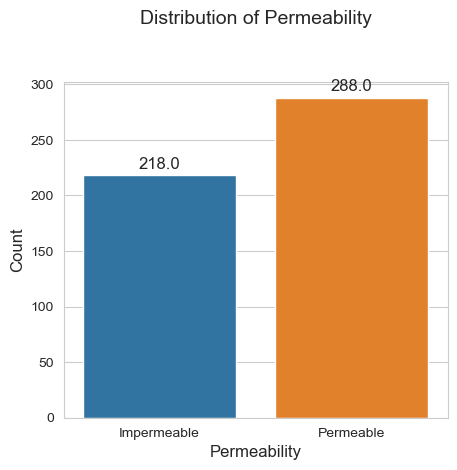

In [7]:
# View the distribution of filtered data.
fig, ax = plt.subplots()
sns.countplot(x='Permeability', data=df, ax=ax)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height), xytext=(0, 3),
                textcoords='offset points', ha='center', va='bottom', fontsize=12)

ax.set_xlabel('Permeability', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.subplots_adjust(top=0.9, bottom=0.2, left=0.2, right=0.8)
fig.suptitle('Distribution of Permeability', fontsize=14, y=1.05)
plt.show()

In [8]:
# We selected these features for machine learning
feature_cols = ['length', 'weight', 'helix_percent',
       'loop_percent', 'mean_bfactor', 'mean_gyrate', 'hydrophobic_index',
       'num_hbonds', 'charge', 'aromaticity', 'isoelectric_point',
       'fraction_arginine', 'fraction_lysine', 'psa']

# drop rows with nan
df[feature_cols].dropna(inplace=True)

value_col = 'Permeability'
df['Value'] = df[value_col].replace({'Permeable': 1, 'Impermeable': 0})

# convert cols to number
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

X_data = df[feature_cols]
y_data = np.array(list(df['Value'].values))

# np.array to dataframe
X = pd.DataFrame(X_data, columns=feature_cols)
y = pd.DataFrame(y_data, columns=['Value'])

X.isnull().sum().sort_values(ascending=False), y.isnull().sum().sort_values(ascending=False)

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_cls = RandomForestClassifier(random_state=42)
rf_cls.fit(X_train, y_train)

# predict
y_pred = rf_cls.predict(X_test)

# evaluate
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8235294117647058
              precision    recall  f1-score   support

           0       0.84      0.77      0.80        47
           1       0.81      0.87      0.84        55

    accuracy                           0.82       102
   macro avg       0.83      0.82      0.82       102
weighted avg       0.82      0.82      0.82       102



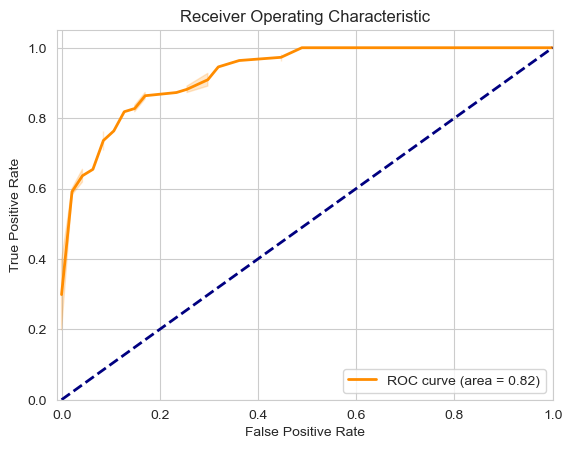

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Calculate the model's prediction probabilities on the test set
# y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
y_pred_proba = rf_cls.predict_proba(X_test)[:, 1]
test_pred = rf_cls.predict(X_test)

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
# roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_test, test_pred)

# Plot the ROC curve
plt.figure()
sns.lineplot(x=fpr, y=tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
sns.lineplot(x=[0, 1], y=[0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [11]:
import pickle

# # save the trained model to disk
filename = '../models/rf_cls_model.pkl'
# pickle.dump(rf_cls, open(filename, 'wb'))

# load the saved model from disk
loaded_model = pickle.load(open(filename, 'rb'))

# make predictions using the loaded model
y_pred = loaded_model.predict(X_test)

Factors Influencing Peptide Membrane Permeability
-------------------------------------------------
The feature importances suggest that the following factors are important for predicting the membrane permeability of peptides:

1.  **Hydrophobic Index:** This is a measure of the hydrophobicity or water-repelling nature of a peptide. Peptides with a higher hydrophobic index tend to have better membrane permeability, as they can more easily cross the hydrophobic barrier of the cell membrane.
    
2.  **Weight:** The molecular weight of a peptide can also influence its membrane permeability. Smaller peptides are generally more permeable than larger ones.
    
3.  **PSA (Polar Surface Area):** This is a measure of the surface area of a peptide that is exposed to polar solvents. Peptides with a lower PSA tend to have better membrane permeability, as they can more easily cross the non-polar, hydrophobic region of the cell membrane.
    
4.  **Mean Gyrate and Mean Bfactor:** These are measures of the flexibility and mobility of a peptide, respectively. Peptides that are more flexible and mobile may be better able to adopt the conformation required for membrane penetration.
    
5.  **Helix Percent and Loop Percent:** These are measures of the secondary structure of a peptide. Peptides that have a higher proportion of alpha helix structure and lower proportion of loop structure tend to have better membrane permeability.
    
6.  **Isoelectric Point:** This is the pH at which a peptide has a net charge of zero. Peptides that have a neutral charge at physiological pH (7.4) tend to have better membrane permeability.
    
7.  **Length, Aromaticity, Charge, Fraction Lysine, Fraction Arginine, and Num Hbonds:** These are other physicochemical properties of the peptide that may influence its membrane permeability. For example, peptides with a higher positive charge or higher fraction of basic amino acids such as lysine and arginine may have better membrane permeability due to interactions with the negatively charged cell membrane. Peptides with a higher number of hydrogen bonds may also have better membrane permeability due to stronger interactions with the cell membrane.

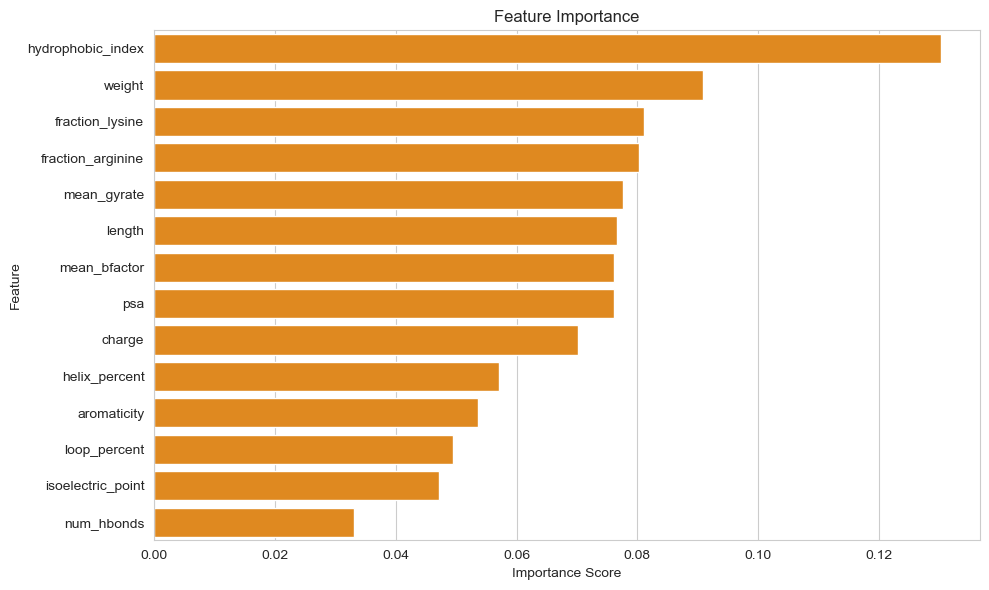

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the feature importances from the best estimator
importance = rf_cls.feature_importances_

# Sort the indices of the feature importances in descending order
sorted_idx = importance.argsort()[::-1]

# Create a figure with a specified size
plt.figure(figsize=(10, 6))

# Create a bar plot of feature importances with a consistent color
sns.barplot(x=importance[sorted_idx], y=X_train.columns[sorted_idx], color='darkorange')

# Set plot title, labels, and adjust layout
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()

# Display the plot
plt.show()

In [13]:
importance = rf_cls.feature_importances_
sorted_idx = importance.argsort()[::-1]

print("Feature Importances:")
for i in range(len(sorted_idx)):
    print("{:<30} {:.3f}".format(X_train.columns[sorted_idx[i]], importance[sorted_idx[i]]))

Feature Importances:
hydrophobic_index              0.130
weight                         0.091
fraction_lysine                0.081
fraction_arginine              0.080
mean_gyrate                    0.078
length                         0.077
mean_bfactor                   0.076
psa                            0.076
charge                         0.070
helix_percent                  0.057
aromaticity                    0.054
loop_percent                   0.049
isoelectric_point              0.047
num_hbonds                     0.033


Multiple models comparison
-------------------------------------------------
This section demonstrates how to evaluate the performance of multiple machine learning models using the Receiver Operating Characteristic (ROC) curve.

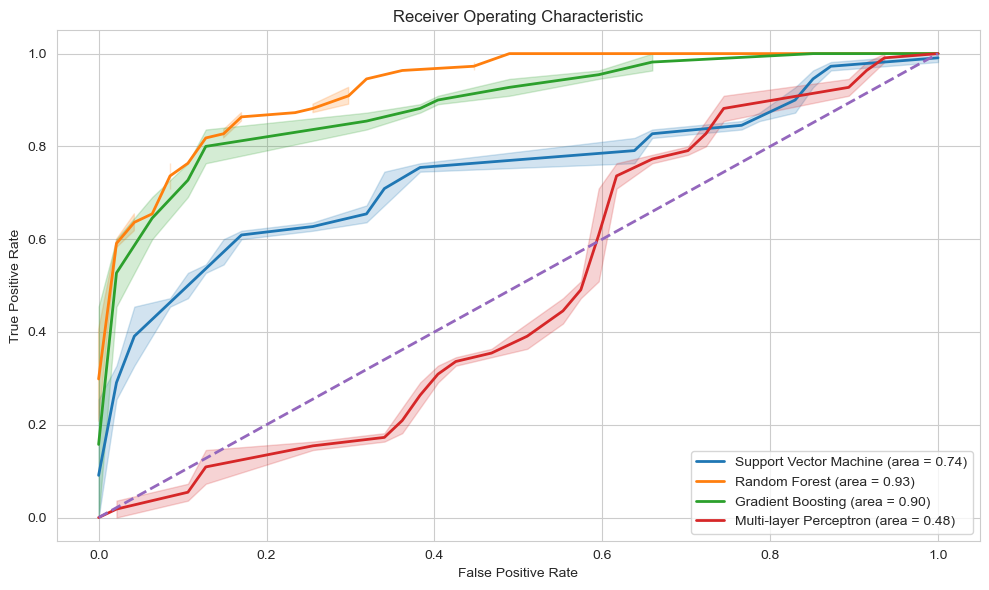

In [14]:
# Import the machine learning models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Instantiate the machine learning models
svc = SVC(random_state=42, probability=True)
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
mlp = MLPClassifier(random_state=42)

# Define a list that contains the machine learning models
models = [svc, rf, gb, mlp]

# Define a list that contains the names of the machine learning models
model_names = ['Support Vector Machine', 'Random Forest', 'Gradient Boosting', 'Multi-layer Perceptron']

# Create a dictionary to store the false positive rates (fpr), true positive rates (tpr), and areas under the ROC curve (AUC) for each model
roc_dict = {}

# Iterate over the machine learning models
for model, model_name in zip(models, model_names):
    # Perform 5-fold cross-validation
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_dict[model_name] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

# Create a figure with a specified size
plt.figure(figsize=(10, 6))

# Plot the ROC curves for each model
for model_name in model_names:
    fpr = roc_dict[model_name]['fpr']
    tpr = roc_dict[model_name]['tpr']
    roc_auc = roc_dict[model_name]['roc_auc']
    sns.lineplot(x=fpr, y=tpr, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')

# Plot the random classifier
sns.lineplot(x=[0, 1], y=[0, 1], lw=2, linestyle='--')

# Set plot title, labels, and adjust layout
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()

# Display the plot
plt.show()